1. Loading and Preparing Data...
   -> Dropping problematic columns: ['record_status___monthly_file_only']
2. Initializing PyCaret Setup...
                    Description             Value
0                    Session id                42
1                        Target             price
2                   Target type        Regression
3           Original data shape     (1124041, 10)
4        Transformed data shape     (1084699, 13)
5   Transformed train set shape      (747486, 13)
6    Transformed test set shape      (337213, 13)
7               Ignore features                 1
8              Numeric features                 2
9          Categorical features                 6
10     Rows with missing values              0.0%
11                   Preprocess              True
12              Imputation type            simple
13           Numeric imputation              mean
14       Categorical imputation              mode
15     Maximum one-hot encoding                20
16        

             MAE           MSE         RMSE      R2   RMSLE    MAPE
Fold                                                               
0     54080.7452  3.878082e+10  196928.4598  0.3886  0.3954  0.3213
1     53322.3260  4.393862e+10  209615.3997  0.3264  0.3914  0.3076
2     52134.9175  3.210714e+10  179184.6549  0.3940  0.3945  0.3216
3     54469.8116  4.842919e+10  220066.3328  0.2293  0.3979  0.3292
4     53259.5988  4.105948e+10  202631.3863  0.3383  0.3965  0.3186
5     53529.9038  4.169336e+10  204189.5312  0.3564  0.3938  0.3120
6     54178.7248  5.402006e+10  232422.1633  0.3359  0.3911  0.3061
7     52556.8808  3.115263e+10  176501.0715  0.4247  0.3900  0.3042
8     53612.0008  4.369256e+10  209027.6436  0.3341  0.3952  0.3059
9     53934.8220  4.626830e+10  215100.6632  0.3053  0.3954  0.3066
Mean  53507.9731  4.211422e+10  204566.7306  0.3433  0.3941  0.3133
Std     691.5652  6.613646e+09   16329.9643  0.0513  0.0024  0.0083

4. Tuning the Model...


Processing:  14%|█▍        | 1/7 [00:00<00:02,  2.90it/s]

Fitting 10 folds for each of 20 candidates, totalling 200 fits


             MAE           MSE         RMSE      R2   RMSLE    MAPE
Fold                                                               
0     53387.7809  3.789859e+10  194675.6088  0.4025  0.3914  0.3084
1     52818.4473  4.304577e+10  207474.7428  0.3401  0.3881  0.3027
2     51520.0233  3.136353e+10  177097.5130  0.4080  0.3904  0.3129
3     52980.8225  3.840119e+10  195962.2135  0.3889  0.3906  0.3084
4     52541.6123  4.035858e+10  200894.4619  0.3496  0.3920  0.3149
5     52948.9058  4.150116e+10  203718.3396  0.3594  0.3891  0.3050
6     53709.7780  5.512529e+10  234787.7576  0.3223  0.3876  0.3019
7     51871.8184  3.058742e+10  174892.6053  0.4351  0.3859  0.3008
8     53088.4648  4.328610e+10  208053.1162  0.3403  0.3912  0.3036
9     53121.1691  4.513638e+10  212453.2418  0.3223  0.3895  0.3026
Mean  52798.8822  4.067040e+10  201000.9600  0.3669  0.3896  0.3061
Std     630.9808  6.657905e+09   16401.7094  0.0372  0.0018  0.0046

6. Generating Plots...


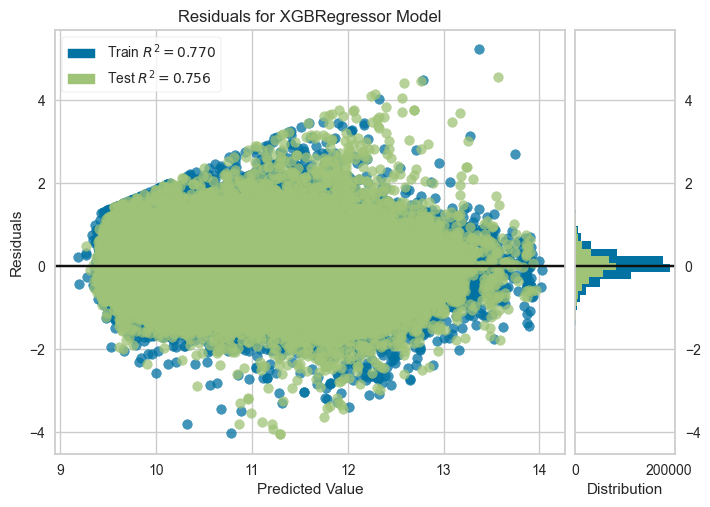

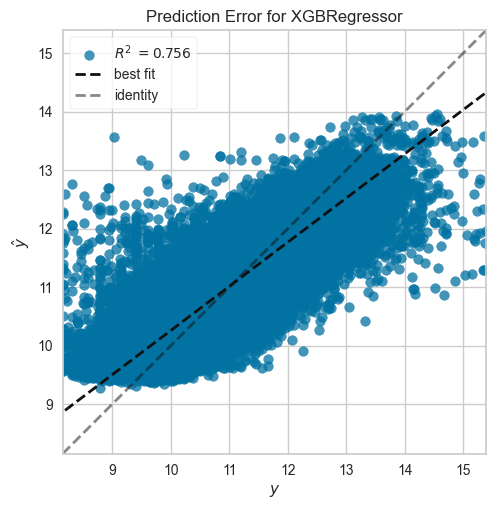


7. Saving Final Version...
Transformation Pipeline and Model Successfully Saved
Done.


In [1]:
from pycaret.regression import *
import pandas as pd
import os

# =============================================================================
# STEP 1: WAKE UP THE BODY (Load Data & Run Setup)
# ============================================================================= 
print("1. Loading and Preparing Data...")
data = pd.read_parquet('./../../data/housing/processed/price_paid_model_ready.parquet')

# --- CLEANING ---
cols_to_drop = [c for c in data.columns if 'record_status' in c]
if cols_to_drop:
    print(f"   -> Dropping problematic columns: {cols_to_drop}")
    data = data.drop(columns=cols_to_drop)

data = data.rename(columns={
    'town/city': 'town_city',
    'old/new': 'old_new',
    'ppdcategory_type': 'ppd_category'
})

# Extract Seasonality
if 'sale_month' not in data.columns:
    data['sale_month'] = data['sale_date'].dt.month

# Sample (Start small to test the fix, increase this to 0.2 or 0.5 later for better R2)
data_subset = data.sample(frac=0.05, random_state=42)

print("2. Initializing PyCaret Setup...")

potential_cats = ['property_type', 'old_new', 'duration', 'town_city', 'district', 'county', 'ppd_category']
actual_cats = [c for c in potential_cats if c in data.columns]

s = setup(
    data = data_subset,
    target = 'price', 
    session_id = 42,
    html = False,
    ignore_features = ['sale_date'],
    categorical_features = actual_cats,
    max_encoding_ohe = 20, 
    
    # --- THE CRITICAL FIXES ---
    transform_target = True,  # <--- THIS FIXES THE SKEWED RESIDUALS
    remove_outliers = True,   # Removes extreme values that confuse the model
    outliers_threshold = 0.05,
    normalize = True,
    imputation_type = 'simple' # Safety net for missing values
)

# =============================================================================
# STEP 2: CREATE FRESH MODEL (Don't load the old broken one)
# =============================================================================
print("\n3. Creating a FRESH XGBoost Model...")
# We create a new model because the old one was trained on raw prices.
# This new one will be trained on Log-Transformed prices.
xgboost = create_model('xgboost')

# =============================================================================
# STEP 3: TUNE
# =============================================================================
print("\n4. Tuning the Model...")
# Optimize for R2 or RMSE. Since we are using log-transform, RMSE is effectively RMSLE.
tuned_xgb = tune_model(xgboost, optimize='R2', n_iter=20)

# =============================================================================
# STEP 4: VISUALIZE
# =============================================================================
print("\n6. Generating Plots...")
# The residuals should now look like a random cloud, not a straight line downwards
plot_model(tuned_xgb, plot='residuals')
plot_model(tuned_xgb, plot='error') # Added Error Plot to see prediction spread

# =============================================================================
# STEP 5: SAVE FINAL VERSION
# =============================================================================
print("\n7. Saving Final Version...")
final_pipeline = finalize_model(tuned_xgb)

save_dir = '../../data/trained_models/housing/'
os.makedirs(save_dir, exist_ok=True)

# Save as v3 to distinguish from the broken v2
save_model(final_pipeline, os.path.join(save_dir, 'housing_pipeline_v4_xgboost'))
print("Done.")

In [2]:
# =============================================================================
# STEP 6: SEE REAL WORLD PERFORMANCE
# =============================================================================

# 1. Run predictions on the Test Set (the 30% held back)
#    PyCaret automatically reverses the Log Transform here!
predictions = predict_model(tuned_lgbm)

# 2. Clean up the dataframe to make it readable
#    'prediction_label' is the model's guess. 'price' is the actual.
results = predictions[['price', 'prediction_label']].copy()

# 3. Calculate the error in Cash
results['Error_Amount'] = results['prediction_label'] - results['price']
results['Error_Percentage'] = (results['Error_Amount'] / results['price']) * 100

# 4. Show a random sample of 10 houses
print("\n--- Random Sample of Predictions ---")
print(results.sample(10))

# 5. Show me the "Best" and "Worst" predictions
print("\n--- Best 5 Predictions (Closest to Reality) ---")
# We use abs() because an error of -1% is just as good as +1%
print(results.iloc[results['Error_Percentage'].abs().argsort()[:5]]) 

print("\n--- Worst 5 Predictions (Biggest Failures) ---")
print(results.iloc[results['Error_Percentage'].abs().argsort()[-5:]])

NameError: name 'tuned_lgbm' is not defined